In [2]:
###############################################################################
#                          Libraries to use
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
import matplotlib.patheffects as path_effects
import pandas as pd
import csv

from lmfit import (Minimizer, minimize, Parameters, Parameter, report_fit, 
                   fit_report)
from scipy.integrate import odeint
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from pylab import *

In [3]:
## Read data into session.

pbt2_data_url = "car_T_pbt2_lines.csv"


pbt_full_fits_url = "pbt2_fit_report_file.csv"


pbt2_data = pd.read_csv(pbt2_data_url)
pbt_full_fits = pd.read_csv(pbt_full_fits_url)

In [4]:
###############################################################################
#                     CARRGO with Dex model
###############################################################################
###############################################################################
#                     ODE system Model re-writing
#       currently hardcoded for modeling with t cells using non T cell fit
#       values.  Uses try/except to toggle use with lmfit (the try) or pyswarm
 #      (the exception)
###############################################################################

def f_dt(xs, t, ps, t_start):
    """CARRGO predator-prey model."""
    rho = ps['rho'].value
    kappainv = ps['kappainv'].value
    kappac1 = ps['kappac1'].value
    kappac2 = ps['kappac2'].value
    theta = ps['theta'].value

    x, y = xs

    return (rho*x - rho*x*x*kappainv - kappac1*x*y,
            kappac2*x*y - theta*y)

def g_fdt(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    t_start = t[0]
    x = odeint(f_dt, x0, t, args=(ps, t_start))
    return x

def rms_fdt(ps, *args):
    x0, ts, data = args
    model = g_fdt(ts, x0, ps)
    res = (model[:,0] - data).ravel()
    rms = np.sqrt(np.mean(res**2))
    return rms

def residual_fdt(ps, *args):
    x0, ts, data, t_fin, t_fin_sigma, sigma= args
    model = g_fdt(ts, x0, ps)
    
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, (model[-1,1] - t_fin)/t_fin_sigma)
    return res


def dex_decay(t, dex_max, t_start):
    return dex_max*(np.exp(-(t-t_start)*np.log(2)/3.33))

In [50]:
###############################################################################
#                     SINDy models
###############################################################################


def sindy_model(xs, t, ps):
    # this try allows us to run the lmfit
    rho_x = ps['rho_x'].value
    kappainv_x = ps['kappainv_x'].value
    Ainv_x = ps['Ainv_x'].value
    rho_y = ps['rho_y'].value
    kappainv_y = ps['kappainv_y'].value
    Ainv_y = ps['Ainv_y'].value
    a = ps['a'].value
    b = ps['b'].value
    c = ps['c'].value
    alpha = ps['alpha'].value
    beta = ps['beta'].value

    x, y = xs

    return (rho_x*x*(1-kappainv_x*x)*(Ainv_x*x + 1) - a*x*y - b*x*y*y,
           rho_y*y*(1-kappainv_y*y)*(Ainv_y*y + 1) + alpha*x*y + beta*x*x*y - c*x*y*y)
    
def h_dt(t, x0, ps):
    t_start = t[0]
    x = odeint(sindy_model, x0, t, args=(ps,))
    return x

def rms_hdt(ps, *args):
    x0, ts, data = args
    model = h_dt(ts, x0, ps)
    res = (model[:,0] - data).ravel()
    rms = np.sqrt(np.mean(res**2))
    return rms

def residual_hdt(ps, *args):
    x0, ts, data, t_fin, t_fin_sigma, sigma = args
    model = h_dt(ts, x0, ps)
    sigma[sigma == 0] = np.mean(sigma)
    res = ((model[:,0] - data)/sigma).ravel()
    res = np.append(res, (model[-1,1] - t_fin)/t_fin_sigma)
    return res

In [51]:
pbt_full_fits

,tumor_line,data_column,t_start_.hr.,t_end_.hr.,dex_.ug.ml.,t_cell_start.ci.,t_cell_end.ci.,chi_sq,red_chi_sq,rho_val,rho_stderr,kappainv_val,kappainv_stderr,kappac1_val,kappac1_stderr,kappac2_val,kappac2_stderr,theta_val,theta_stderr
0,PBT2,"Y(G1,G2)",125,345,0,0.250,0.5580,6847.952953,13.093600,0.470864,0.003700,0.270507,0.016985,0.554936,0.056451,0.031874,0.002500,0.001817,0.000349
1,PBT2,"Y(F1,F2)",125,652,0,0.125,0.3206,3.051664,0.005835,0.358709,0.002614,0.175863,0.002154,1.046632,0.014421,0.015868,0.000176,0.013713,0.000147
2,PBT2,"Y(E1,E2)",125,652,0,0.050,0.2164,9.493928,0.018153,0.228900,0.013356,0.162551,0.011788,1.511460,0.298837,0.024407,0.003782,0.064473,0.010018


In [52]:
pbt2_data

,Time (Hour),"Y(E1,E2)","SD(E1,E2)","Y(F1,F2)","SD(F1,F2)","Y(G1,G2)","SD(G1,G2)"
0,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000
1,0.004722,0.00120,0.001273,0.00080,0.000849,-0.00165,0.001485
2,0.254722,-0.00995,0.008980,-0.02690,0.008344,-0.04550,0.006647
3,1.289444,0.12915,0.003748,0.12055,0.011667,0.12740,0.007778
4,1.539722,0.23370,0.016122,0.20965,0.003889,0.19785,0.010536
...,...,...,...,...,...,...,...
647,163.481944,3.03850,0.408283,1.02780,0.302925,-0.15905,0.009546
648,163.732222,3.05075,0.415567,1.02870,0.296702,-0.15875,0.010677
649,163.982222,3.05640,0.414930,1.03150,0.291045,-0.15935,0.009122
650,164.236667,3.05935,0.415991,1.03375,0.298187,-0.15880,0.011031


In [53]:
## Data/fit table accession for PBT128+ (PBT 2)

## Practice grabbing one columne of data, predicting, and plotting both.
## Initializing values.

start_t = [125, 125, 125]
end_t = [345, 652, 652]
data_column_t = ['Y(G1,G2)', 'Y(F1,F2)', 'Y(E1,E2)']

sigma_column_t = ['SD(G1,G2)', 'SD(F1,F2)', 'SD(E1,E2)']

# DEFINE THESE USING fit_rows AND data_column_t AND DYNAMIC INDEXING.
fit_rows = [0,1,2]

data_char_sym = ['o', '*', 'x']
data_fit_char_col = ['k','k','k']
data_fit_char_sym = ['-','-','-']

tcell_char_col = ['k-','k--','k-.']
tcell_fit_char_col = ['m-','c--','g-.']
tcell_fin_sigma = [0.0143, 0.0727, 0.0255]

## We hardcode the model parameter values taken from the paper.

sindy_params = np.array([[0.121, 0.2086, 0.7037, 0.191, 1.8382, 0, 0, 0.593, 0, 0.035, -0.009],
                       [0.237, 0.1559, 0.3246753, 0.112, 3.1948882, 0, 0.626, 0, 0, 0.051, -0.0096],
                       [0.15, 0.08, 0, 0.0, 0.0, 0.0, 0.545, 0, 0.063, -0.002, 0.005]])

vary_parms = np.array([[True, True, True, True, True, False, False, True, False, True, True],
                      [True, True, True, True, True, False, True, False, False, True, True],
                      [True, True, False, False, False, False, True, False, True, True, True]])


upper_bound_patch = np.array([[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
                             [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
                             [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0]])

var_names = ['rho_x', 'kappainv_x', 'Ainv_x', 'rho_y', 'kappainv_y', 'Ainv_y', 'a', 'b', 'c', 'alpha', 'beta']
legend_labels = ['E:T = 1:4', 'E:T = 1:8', 'E:T = 1:20']


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 51
    # data points      = 528
    # variables        = 5
    chi-square         = 7105.24716
    reduced chi-square = 13.5855586
    Akaike info crit   = 1382.53206
    Bayesian info crit = 1403.87754
[[Variables]]
    rho:       0.47105257 +/- 0.00303374 (0.64%) (init = 0.4708645)
    kappainv:  0.27052608 +/- 0.00103513 (0.38%) (init = 0.2705072)
    kappac1:   0.55534904 +/- 0.00887763 (1.60%) (init = 0.554936)
    kappac2:   0.03187711 +/- 3.7468e-04 (1.18%) (init = 0.03187423)
    theta:     0.00182219 +/- 1.7300e-04 (9.49%) (init = 0.001817259)
[[Correlations]] (unreported correlations are < 0.100)
    C(kappac1, kappac2)  = -0.996
    C(rho, kappac2)      = -0.991
    C(rho, kappac1)      = 0.990
    C(kappainv, kappac1) = -0.976
    C(rho, theta)        = -0.972
    C(kappainv, kappac2) = 0.967
    C(kappac2, theta)    = 0.959
    C(rho, kappainv)     = -0.946
    C(kappac1, theta)    = -0.942
    C(

C:\Users\brummerab\Anaconda3\lib\site-packages\lmfit\printfuncs.py:175: RuntimeWarning: invalid value encountered in double_scalars
  spercent = f'({abs(par.stderr/par.value):.2%})'


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 524
    # data points      = 528
    # variables        = 8
    chi-square         = 6271.82903
    reduced chi-square = 12.0612097
    Akaike info crit   = 1322.65587
    Bayesian info crit = 1356.80864
[[Variables]]
    rho_x:       0.11773859 +/- 0.26523210 (225.27%) (init = 0.121)
    kappainv_x:  0.20880128 +/- 0.05654796 (27.08%) (init = 0.2086)
    Ainv_x:      0.84160600 +/- 3.15980960 (375.45%) (init = 0.7037)
    rho_y:       0.22919969 +/- 0.07636624 (33.32%) (init = 0.191)
    kappainv_y:  1.73513808 +/- 0.14950938 (8.62%) (init = 1.8382)
    Ainv_y:      0 (fixed)
    a:           0 (fixed)
    b:           0.64355968 +/- 0.80872753 (125.66%) (init = 0.593)
    c:           0 (fixed)
    alpha:       0.02840993 +/- 0.11669756 (410.76%) (init = 0.035)
    beta:       -0.00818341 +/- 0.02618213 (319.94%) (init = -0.009)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_x, Ainv_x)     

C:\Users\brummerab\Anaconda3\lib\site-packages\lmfit\printfuncs.py:175: RuntimeWarning: invalid value encountered in double_scalars
  spercent = f'({abs(par.stderr/par.value):.2%})'


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 515
    # data points      = 528
    # variables        = 6
    chi-square         = 1852.02735
    reduced chi-square = 3.54794511
    Akaike info crit   = 674.608265
    Bayesian info crit = 700.222843
[[Variables]]
    rho_x:       0.12307189 +/- 0.00554454 (4.51%) (init = 0.15)
    kappainv_x:  0.09047226 +/- 0.00516976 (5.71%) (init = 0.08)
    Ainv_x:      0 (fixed)
    rho_y:       0 (fixed)
    kappainv_y:  0 (fixed)
    Ainv_y:      0 (fixed)
    a:           0.53940680 +/- 0.09840365 (18.24%) (init = 0.545)
    b:           0 (fixed)
    c:           0.07560000 +/- 0.00304841 (4.03%) (init = 0.063)
    alpha:      -0.00239998 +/- 0.00223181 (92.99%) (init = -0.002)
    beta:        0.00600000 +/- 2.1667e-04 (3.61%) (init = 0.005)
[[Correlations]] (unreported correlations are < 0.100)
    C(c, beta)          = -0.998
    C(rho_x, a)         = 0.979
    C(a, alpha)         = -0.822
    C(rho_x, alpha) 

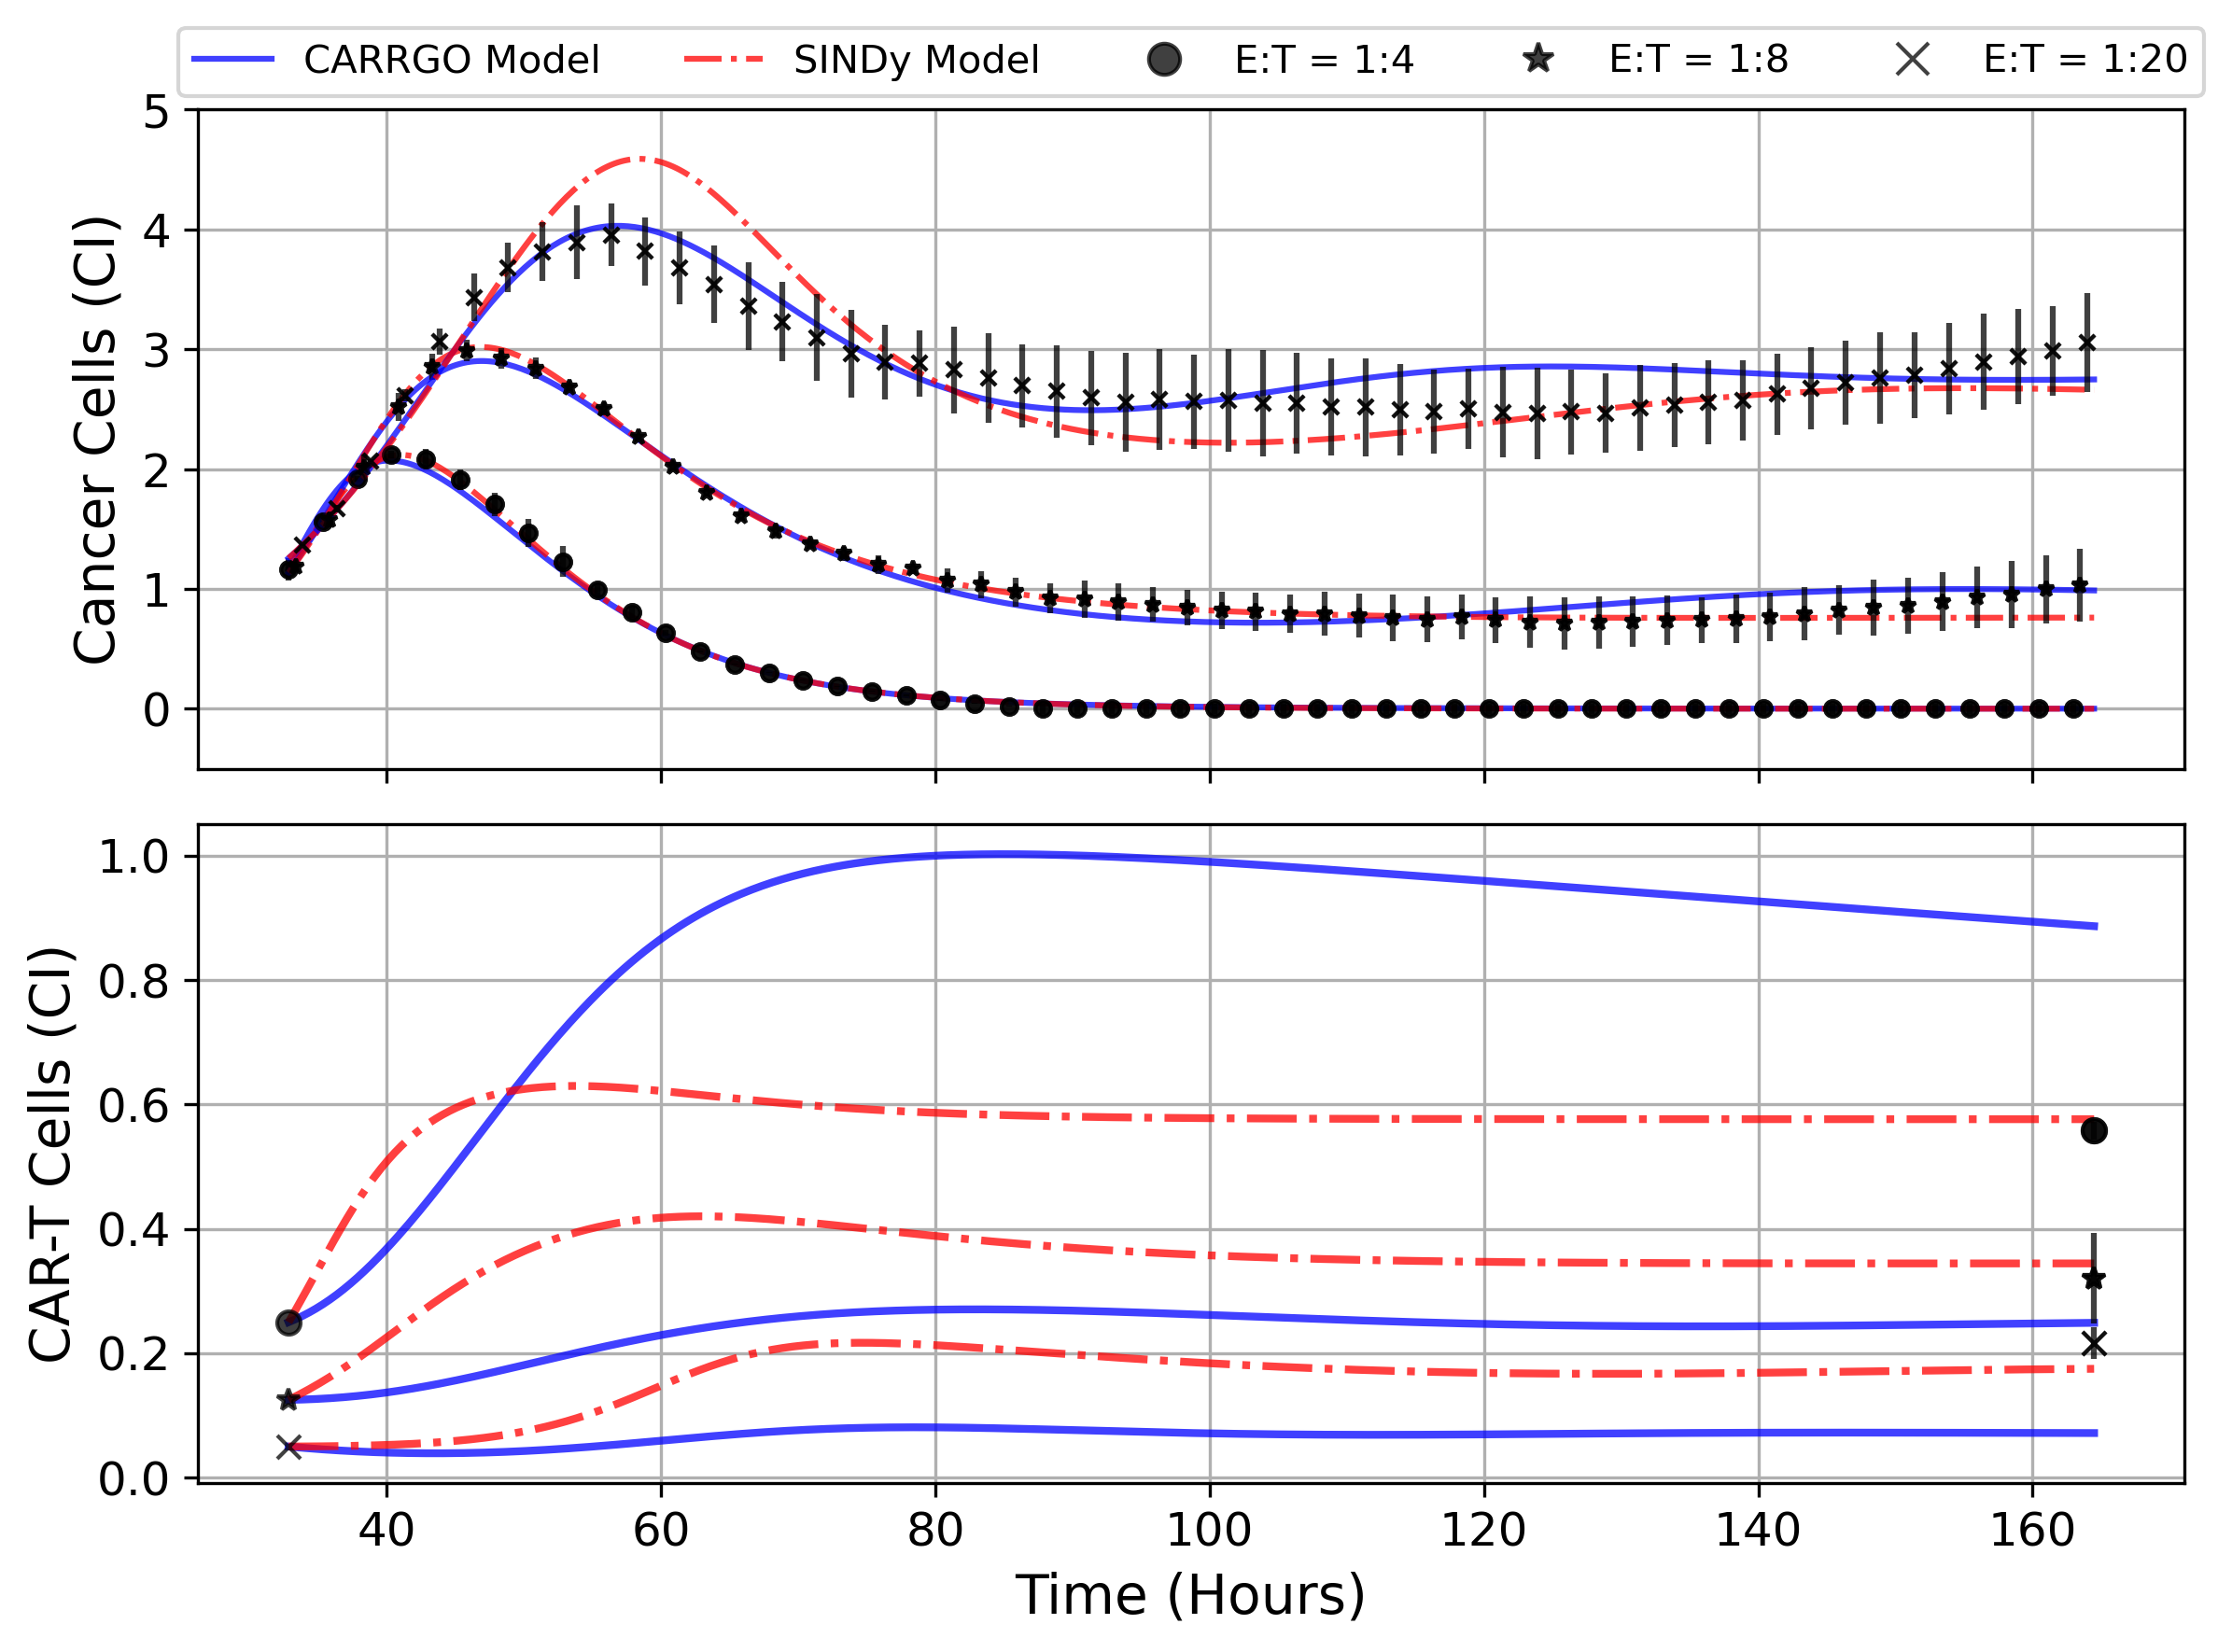

In [54]:
## Data/fit table accession for PBT128+ (PBT 12) High CAR-T


## Formatting block for SI notation
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
fmt = mticker.FuncFormatter(g)

result_fdt = []
result_hdt = []

plt.figure(num=None, figsize=(8, 6), dpi=300)
for i in range(0,3):
    

    ## Grab data to be fit.
    data_fit = np.array(pbt2_data[['Time (Hour)', 
                                  data_column_t[i]]])[start_t[i]:end_t[i],:]
    data_sigma = np.array(pbt2_data[['Time (Hour)', sigma_column_t[i]]])[start_t[i]:end_t[i],:]
    
    if end_t[i] != 652:
        new_time = np.array(pbt2_data[['Time (Hour)']])[end_t[i]:652,:]
        new_sigma = np.mean(data_sigma[:,1])
        extend_length = 652-end_t[i]
        # append zeros to dxata_fit equal to difference in end_t[i] and 652
        data_fit = np.append(data_fit, np.append(new_time, np.repeat(0, extend_length).reshape(-1,1), 
                                                 axis = 1), axis = 0)        
        # append average sigma to data_sigma equal to difference in end_t[i] and 652
        data_sigma = np.append(data_sigma, np.append(new_time, np.repeat(new_sigma, extend_length).reshape(-1,1),
                                                     axis = 1), axis = 0)


    ## Here we set up parameters and fits for CARRGO model.
        
    model_params = np.array(pbt_full_fits[['rho_val','kappainv_val',
                                           'kappac1_val','kappac2_val','theta_val']])[fit_rows[i],:]
    
    t_cell_start_t = np.array(pbt_full_fits[['t_cell_start.ci.']])[fit_rows[i],0]
    t_cell_fin_t = np.array(pbt_full_fits[['t_cell_end.ci.']])[fit_rows[i],0]
    t = data_fit[:,0]
    x0 = np.array([data_fit[0,1],t_cell_start_t])
    
    
    params0 = Parameters()
    params0.add('rho', value= model_params[0], min= model_params[0]*0.8, max= model_params[0]*1.2, vary = True)  
    params0.add('kappainv', value= model_params[1], min=model_params[1]*0.8, max=model_params[1]*1.2, vary = True)
#     params0.add('c0', value= model_params[2], min=model_params[2]*0.8, max=model_params[2]+1.2, vary = False)
    params0.add('kappac1', value= model_params[2], min= model_params[2]*0.8, max= model_params[2]*1.2, vary = True)
    params0.add('kappac2', value= model_params[3], min= model_params[3]*0.8, max= model_params[3]*1.2, vary = True)
    params0.add('theta', value= model_params[4], min= model_params[4]*0.8, max= model_params[4]*1.2, vary = True)
#     params0.add('c3', value= model_params[6], min= model_params[6]*0.8, max= model_params[6]+1.2, vary = False)

    
    ## Grab final tcell sigma value.
    tcell_fin_sigma_val = tcell_fin_sigma[i]
    
    # Fit data with CARRGO Model.
    result_fdt_temp = minimize(residual_fdt, params0, args=(x0, t, data_fit[:,1], 
                                                            t_cell_fin_t, tcell_fin_sigma_val, 
                                                            data_sigma[:,1]), method='leastsq')
    result_fdt.append(result_fdt_temp)
    
    prediction = g_fdt(t,x0,result_fdt[i].params)
    
    ## Print fit statistics.
    print(fit_report(result_fdt[i]))
    
    
    
    ## Here we set up parameters and fits for SINDy models.
    sindy_mod_parms = sindy_params[i]
    sindy_vary_parms = vary_parms[i]
    sindy_up_bd = upper_bound_patch[i]
    
    params1 = Parameters()
    for j in range(0,len(var_names)):
        params1.add(var_names[j], value = sindy_mod_parms[j], min = sindy_mod_parms[j]*0.8, 
                    max =sindy_mod_parms[j]*1.2+sindy_up_bd[j], vary =sindy_vary_parms[j])
    
    result_hdt_temp = minimize(residual_hdt, params1, args=(x0, t, data_fit[:,1], 
                                                            t_cell_fin_t, tcell_fin_sigma_val, 
                                                            data_sigma[:,1]), method='leastsq')
    result_hdt.append(result_hdt_temp)
    sindy_prediction = h_dt(t,x0,result_hdt[i].params)
    print(fit_report(result_hdt[i]))
 
    
    ## Plotting the predicted and measured cancer cell trajectories.
    
    
    ax1 = plt.subplot(2,1,1)
    if i == 0:
        plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], 
                 color = 'blue', alpha = 0.75, label = 'CARRGO Model')
        plt.plot(t, sindy_prediction[:,0], linestyle = '-.', 
                 color = 'red', alpha = 0.75, label = 'SINDy Model')
    else:
        plt.plot(t, prediction[:,0], linestyle = data_fit_char_sym[i], color = 'blue', alpha = 0.75)
        plt.plot(t, sindy_prediction[:,0], linestyle = '-.', color = 'red', alpha = 0.75)
        

    plt.errorbar(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)], 
                 data_sigma[:,1][np.arange(2*i,len(t), 10)], marker = data_char_sym[i], color = 'k', 
                 linestyle = 'None', alpha = 0.75, markersize = 4)
    
    plt.plot(t[np.arange(2*i,len(t), 10)], data_fit[:,1][np.arange(2*i,len(t), 10)], 
             marker = data_char_sym[i], color = 'k', 
             linestyle = 'None', label = str(legend_labels[i]),
            markersize = 4, alpha = 0.75)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylim(-0.5,5)
    ax1.legend(bbox_to_anchor=(-0.01,1.02,1.02,0.2), loc="lower left",
               mode="expand", borderaxespad=0, ncol=6,
               fontsize = 'medium', markerscale = 2, handlelength = 2)
    plt.yticks(fontsize = 12)
    ax1.grid(True)
    plt.ylabel('Cancer Cells (CI)', fontsize = 14)

    
    ## Plotting the predicted and measured CAR T-cell trajectories.
    ax2 = plt.subplot(2,1,2, sharex = ax1)
    plt.plot(t, prediction[:,1], linestyle = data_fit_char_sym[i],
             color = 'blue', label = 'CARRGO Model', linewidth=2, alpha = 0.75)
    plt.plot(t, sindy_prediction[:,1], linestyle = '-.',
         color = 'red', label = 'SINDy Model', linewidth=2, alpha = 0.75)
    plt.plot(t[-1], t_cell_fin_t, marker = data_char_sym[i], color = 'k',
            alpha = 0.75, markersize = 6)
    plt.errorbar(t[-1], t_cell_fin_t, tcell_fin_sigma[i], 
                 marker = data_char_sym[i], color = 'k', 
             linestyle = 'None', alpha = 0.75, markersize = 6)
    plt.plot(t[0], t_cell_start_t, marker = data_char_sym[i], color = 'k',
            alpha = 0.75, markersize = 6)
    plt.setp(ax2.get_xticklabels(), visible=True, fontsize = 12)
    plt.ylabel('CAR-T Cells (CI)', fontsize = 14)
    plt.yticks(fontsize = 12)
    plt.xlabel('Time (Hours)', fontsize = 14)
    ax2.grid(True)
    plt.tight_layout()
    

plt.show()
